In [1]:
%matplotlib inline
import io
import pickle


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils.extmath import log_logistic
from scipy.optimize import minimize


def process(data_string):
    try:
        return np.array(
            data_string.replace('\n', '').strip().split(' '), 
            dtype=np.longdouble
        )
    except ValueError:
        return ''

def get_data(verbose=False):
    with io.FileIO('ex3data1.dat') as file:
        # Throw out the header lines:
        for _ in range(5):
            line = file.readline()
            if verbose:
                print line
        data = [process(line) for line in file]
        # Throw out the footer lines:
        disguard1 = data.pop()
        disguard2 = data.pop()
        return np.array(data), disguard1, disguard2


def pickle_data(data):
    with open('ex3data1_py.dat', 'w') as file:
        s = pickle.dumps(data)
        file.write(s)
        
data128, d1, d2 = get_data()
assert not d1
assert not d2
assert data128.shape == (5000, 400)
        
def transpose():
    """ Likely because Octave is column-major and numpy is row-major, each image when loaded is transposed. """
    m, n = data128.shape
    assert n == 400
    for index, row in enumerate(data128):
        transposed = row.reshape(20, 20).T.reshape(1, n)
        data128[index, :] = transposed
transpose()
    

def get_labels():
    with io.FileIO('y.dat') as file:
        return np.array([np.int(float(line)) for line in file.readlines()])
        
y0 = get_labels()
y = y0.copy()    
# Octave uses 1-indexing, so to prevent confusion, MNIST '0's were labelled as '10'. 
y[y == 10] = 0

print 'done'

done


# Logistic regression cost functions:

In [2]:
def sigmoid(z):
    idx = z > 0
    out = np.zeros(z.shape)
    out[idx] = 1/(1 + np.exp(-z[idx]))
    out[~idx] = np.exp(z[~idx])/(np.exp(z[~idx]) + 1)
    return out


def cost_0(z):
    idx = z > 0
    out = np.zeros(z.shape)
    out[idx] = z[idx] + np.log1p(np.exp(-z[idx]))
    out[~idx] = np.log1p(np.exp(z[~idx]))
    return out


def cost_1(z):
    idx = z > 0
    out = np.zeros(z.shape)
    out[idx] = np.log1p(np.exp(-z[idx]))
    out[~idx] = -z[~idx] + np.log1p(np.exp(z[~idx]))
    return out


def cost(theta, X, y, lambd, debug, **kwargs):
    """ Logistic regression cost function with optional regularization. `Lambd` is the regularization constant. """
    m = X.shape[0]
    XT = X.dot(theta)
    cost1 = cost_1(XT)
    cost0 = cost_0(XT)
    j = y.dot(cost1)  + (1 - y).dot(cost0)
    regularization = (float(lambd)/float(2*m)) * theta[1:].dot(theta[1:].T)
    j /= m
    j += regularization
    return j


def grad(theta, X, y, lambd, debug, **kwargs):
    """ Logistic regression gradient function with optional regularization. `Lambd` is the regularization constant. """

    m = X.shape[0]
    regularization_theta = theta.copy()
    regularization_theta[0] = 0
    return ((sigmoid(X.dot(theta)) - y).dot(X))/m + (float(lambd)/m)*regularization_theta.astype(float)

In [4]:
number_classes = len(set(y))
m, features = data128.shape
X0 = data128.copy()
Theta = np.zeros((number_classes, features + 1))
initial_theta = np.zeros(features+1)
X = np.concatenate([np.ones((X0.shape[0], 1)), X0], axis=1)
debug = False

def train(X, y, lambd=0.1, maxiter=None, disp=True):
    options = {'disp': disp, 'maxiter': maxiter}
    for klass in range(len(set(y))):
        print 'starting with %s' % klass
        result = minimize(
            fun=cost, 
            x0=initial_theta, 
            method='CG',
            args=(X, (y==klass).astype(np.int), lambd, debug), 
            jac=grad,
            options=options
        )

        if not result.success:
            print ">>> Failed for %s" % klass
        Theta[klass, :] = result.x

train(X, y)
print 'done!'


starting with 0
Optimization terminated successfully.
         Current function value: 0.008581
         Iterations: 154
         Function evaluations: 942
         Gradient evaluations: 942
starting with 1
Optimization terminated successfully.
         Current function value: 0.013137
         Iterations: 186
         Function evaluations: 1147
         Gradient evaluations: 1147
starting with 2
Optimization terminated successfully.
         Current function value: 0.050808
         Iterations: 279
         Function evaluations: 1081
         Gradient evaluations: 1081
starting with 3
Optimization terminated successfully.
         Current function value: 0.057606
         Iterations: 399
         Function evaluations: 1522
         Gradient evaluations: 1522
starting with 4
Optimization terminated successfully.
         Current function value: 0.033078
         Iterations: 249
         Function evaluations: 1104
         Gradient evaluations: 1104
starting with 5
Optimization terminat

In [5]:
prediction_matrix = X.dot(Theta.T)
predictions = np.argmax(prediction_matrix, axis=1)
print float(sum(predictions == y))/X.shape[0]


0.9646


# What does it get wrong?

(array([  1.,   0.,   2.,  11.,  17.,  21.,  14.,  17.,  12.,   5.]),
 array([-3.02389255, -2.51305726, -2.00222196, -1.49138667, -0.98055137,
        -0.46971608,  0.04111922,  0.55195451,  1.06278981,  1.5736251 ,
         2.0844604 ]),
 <a list of 10 Patch objects>)

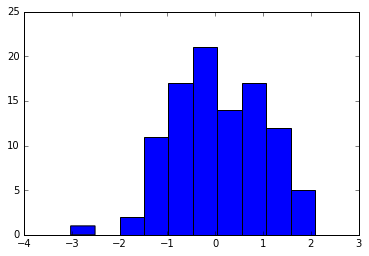

In [42]:
plt.hist(np.random.normal(size=100))

In [92]:
def graph_predictions(predictions):
    fig = plt.figure(figsize=(12, 2))
    ax = fig.add_subplot(111)
    ax.stackplot(range(10), probabilities)
    ax.axhline(np.max(probabilities), color='r')
    ax.axvline(np.argmax(probabilities), color='r')
    plt.show()
    

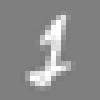

Predicted as: 8
With: [-14.124132 -12.926325 -4.2947064 -10.310617 -9.3745499 -7.93639 -26.084916
 -4.8061576  1.7567279 -5.4532875]
Actually is: 2


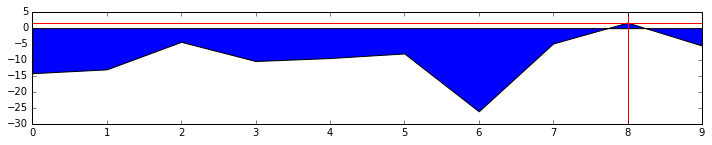

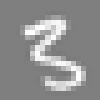

Predicted as: 8
With: [-12.272938 -11.177516 -1.7952177 -1.8548314 -16.4024 -7.3912446 -14.88252
 -17.294501 -1.555529 -7.0842214]
Actually is: 3


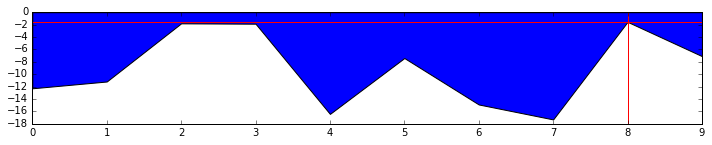

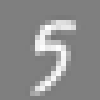

Predicted as: 6
With: [-7.7920705 -14.8643 -3.4476052 -1.4427624 -27.478473 -9.6508648
 -0.80578577 -20.581143 -14.146285 -21.136105]
Actually is: 5


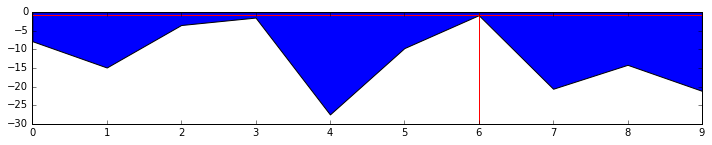

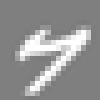

Predicted as: 0
With: [-1.573696 -40.795321 -6.0351783 -10.386157 -11.478108 -11.170826
 -1.9940518 -7.5672139 -11.781067 -10.591419]
Actually is: 7


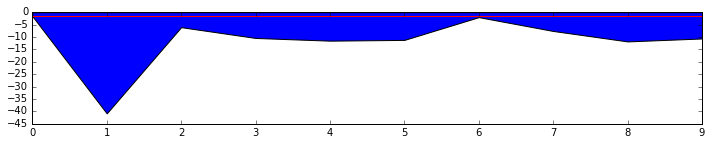

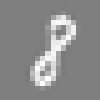

Predicted as: 1
With: [-41.216695 -1.1842139 -5.8503922 -3.5032997 -6.8876354 -6.024659
 -17.275934 -10.164237 -2.5168379 -6.9279634]
Actually is: 8


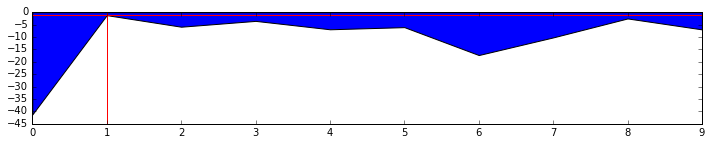

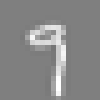

Predicted as: 4
With: [-19.000278 -12.307758 -7.6397802 -8.4785942  1.5989876 -7.5007191
 -12.531387 -8.0889986 -9.5590053  1.3570268]
Actually is: 9


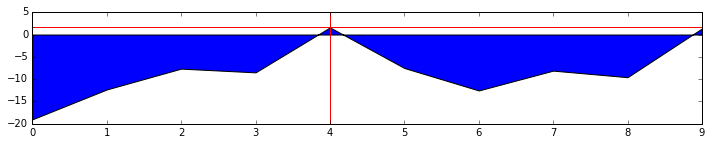

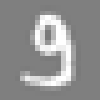

Predicted as: 4
With: [-12.70834 -16.969831 -9.5951615 -11.088109 -0.21859908 -12.764086
 -12.448643 -3.7273076 -3.9590572 -0.88840596]
Actually is: 9


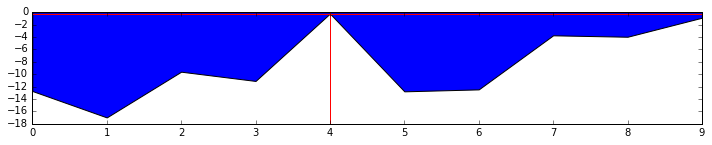

In [101]:
import matplotlib.pyplot as plt

wrong_predictions = predictions[predictions != y]

counter = 0
for prediction, probabilities in zip(wrong_predictions, prediction_matrix[predictions != y]):
    counter += 1
    if counter % 25 == 0:
        img = row2image(X[predictions != y][counter, 1:])
        img.resize((100, 100))
        display(img)
        print 'Predicted as: {}'.format(prediction)
        print 'With: {}'.format(probabilities)
        print 'Actually is: {}'.format(y[predictions != y][counter])
        graph_predictions(predictions)
        print '=' * 100
        


In [135]:
def plot_image_row(figure, images):    
    number_images = len(images)
    layout = '1{number_images}{position}'.format
    for position, image in enumerate(images):
        subplot = figure.add_subplot(layout(number_images=number_images, position=position+1))
        subplot.axes.get_yaxis().set_visible(False)
        subplot.axes.get_xaxis().set_visible(False)
        subplot.imshow(image)
    plt.show()

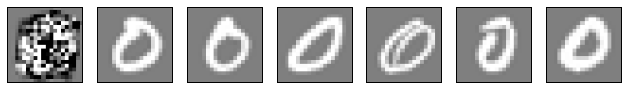

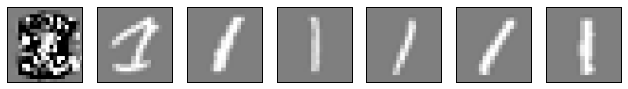

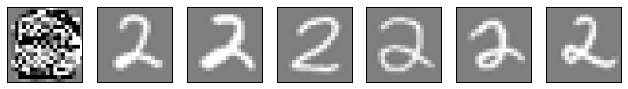

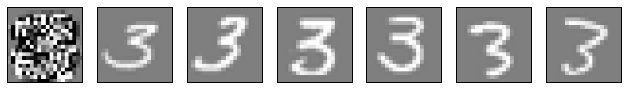

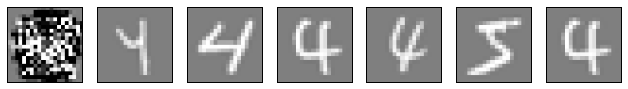

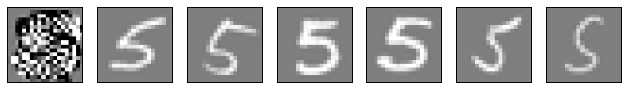

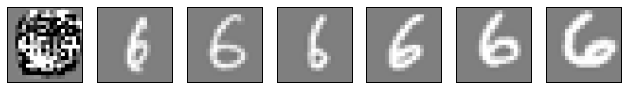

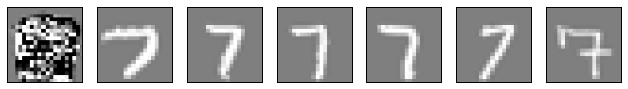

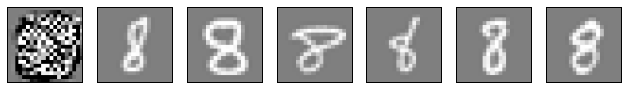

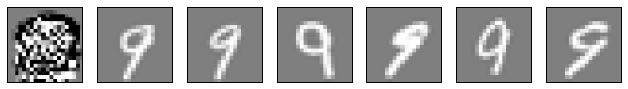

In [156]:
predictor = row2image(Theta[0, 1:])
predictor
for index, row in enumerate(Theta):
    images = [row2image(row[1:])]
    for random_number in np.random.randint(0, 501, size=6):
        random_datum = X[500*index + random_number, 1:]
        images.append(row2image(random_datum))        
    plot_image_row(plt.figure(figsize=(11, 8)), images)
    